In [1]:
!pip install ultralytics insightface onnxruntime scikit-learn opencv-python --quiet

import kagglehub
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from ultralytics import YOLO
from insightface.app import FaceAnalysis
from google.colab import files
import cv2 as cv

# Download latest version
path = kagglehub.dataset_download("hearfool/vggface2")

print("Path to dataset files:", path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 2.32G/2.32G [01:21<00:00, 30.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hearfool/vggface2/versions/1


In [2]:
YOLO_MODEL = "yolov8n.pt" #modelo do yolo para detecção dos rostos
CONF_THRESH = 0.5


detector = YOLO(YOLO_MODEL)
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(640, 640))


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:05<00:00, 53140.89KB/s]
/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [3]:
def embedding_from_crop(face_crop):
  faces = app.get(face_crop)
  if len(faces) == 0:
    return None
  return faces[0].normed_embedding

In [6]:
indices = ["n000020","n000002","n000003","n000004"]
X,y = [],[]
i = 0
#descomente esse caso queira usar o dataset inteiro
#for files in ["train","val"]:
#  path_train_val = os.path.join(path, files)

#  for person in os.listdir(path_train_val):
#      person_path = os.path.join(path_train_val, person)
#
#      if not os.path.isdir(person_path):
#        continue
#
#      for image in os.listdir(person_path):
#          image_path = os.path.join(person_path, image)
#
#          if not image.lower().endswith((".jpg", ".jpeg", ".png")):
#              continue

#          img = cv.imread(image_path)
#          if img is None:
#              continue
#
#          results = detector.predict(source = img, conf=CONF_THRESH,verbose = False)
#
#          for r in results:
#              for b in r.boxes:
#                  x1,y1,x2,y2 = b.xyxy[0].cpu().numpy().astype(int)
#                  face_crop = img[y1:y2, x1:x2]
#                  embedding = embedding_from_crop(face_crop)
#
#                  if embedding is None:
#                      continue

#                  X.append(embedding)
#                  y.append(person)



for files in ["train","val"]: # vai nas imagens pegando os embeddings de cada uma
  path_train_val = os.path.join(path, files)

  for person in os.listdir(path_train_val):
      print("Person : " + str(i))
      i = i + 1
      if person not in indices:
        continue
      person_path = os.path.join(path_train_val, person)

      if not os.path.isdir(person_path):
        continue

      for image in os.listdir(person_path):
          image_path = os.path.join(person_path, image)

          if not image.lower().endswith((".jpg", ".jpeg", ".png")):
              continue

          img = cv.imread(image_path)
          if img is None:
              continue

          results = detector.predict(source = img, conf=CONF_THRESH,verbose = False)

          for r in results:
              for b in r.boxes:
                  x1,y1,x2,y2 = b.xyxy[0].cpu().numpy().astype(int)
                  face_crop = img[y1:y2, x1:x2]
                  embedding = embedding_from_crop(face_crop)

                  if embedding is None:
                      continue

                  X.append(embedding)
                  y.append(person)



Person : 0
Person : 1
Person : 2
Person : 3
Person : 4
Person : 5
Person : 6
Person : 7
Person : 8
Person : 9
Person : 10
Person : 11
Person : 12
Person : 13
Person : 14
Person : 15
Person : 16
Person : 17
Person : 18
Person : 19
Person : 20
Person : 21
Person : 22
Person : 23
Person : 24
Person : 25
Person : 26
Person : 27
Person : 28
Person : 29
Person : 30
Person : 31
Person : 32
Person : 33
Person : 34
Person : 35
Person : 36
Person : 37
Person : 38
Person : 39
Person : 40
Person : 41
Person : 42
Person : 43
Person : 44
Person : 45
Person : 46
Person : 47
Person : 48
Person : 49
Person : 50
Person : 51
Person : 52
Person : 53
Person : 54
Person : 55
Person : 56
Person : 57
Person : 58
Person : 59
Person : 60
Person : 61
Person : 62
Person : 63
Person : 64
Person : 65
Person : 66
Person : 67
Person : 68
Person : 69
Person : 70
Person : 71
Person : 72
Person : 73
Person : 74
Person : 75
Person : 76
Person : 77
Person : 78
Person : 79
Person : 80
Person : 81
Person : 82
Person : 83
Pe

In [7]:
X = np.array(X)
Y = np.array(y)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

clf = SVC(kernel='linear', probability=True)
clf.fit(X, y_encoded)

SVC(kernel='linear', probability=True)

In [9]:
def reconhecer(img): # metodo pra detectar e recionhecer a partir de uma imagem
  img = cv.imread(img)
  results = detector.predict(source=img, conf=CONF_THRESH, verbose=False)
  for r in results:
        for b in r.boxes:
            x1,y1,x2,y2 = b.xyxy[0].cpu().numpy().astype(int)
            face_crop = img[y1:y2, x1:x2]
            embedding = embedding_from_crop(face_crop)
            if embedding is None:
                continue
            probs = clf.predict_proba([embedding])[0]
            idx = np.argmax(probs)
            nome = le.inverse_transform([idx])[0]
            conf = probs[idx]
            cv.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
            cv.putText(img, f"{nome} ({conf:.2f})", (x1, y1-10),
                        cv.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
            return img



Saving teste2.png to teste2.png


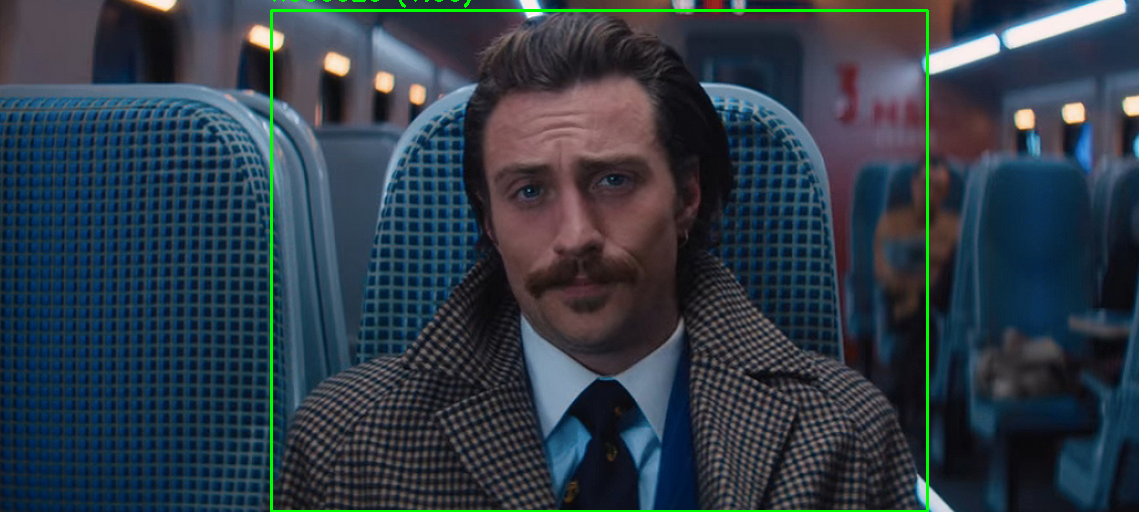

In [12]:
from google.colab import files
test = files.upload() # faz um upload de uma imagem do computador
test_img_path = list(test.keys())[0]
img = reconhecer(test_img_path)
cv.imwrite("resultado.jpg", img)

from google.colab.patches import cv2_imshow
cv2_imshow(img)